In [244]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Obtain training and validation data

In [245]:
image_size = (72, 72)
input_shape = (72, 72, 3)

# Use image_dataset_from_directory to easily acquire images and their labels.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/spots',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/spots',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)

Found 818 files belonging to 3 classes.
Using 655 files for training.
Found 818 files belonging to 3 classes.
Using 163 files for validation.


# Convert from TensorFlow Dataset to numpy for easy manipulation

In [246]:
# Training data
X_train, y_train = [], []
for image, label in train_ds:
    X_train.append(image)
    y_train.append(np.array(label))
X_train = np.array(X_train, dtype=np.uint8)
X_train = X_train.reshape((X_train.shape[0],) + input_shape)
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0],) + (y_train.shape[-1],))

# Validation data
X_val, y_val = [], []
for image, label in val_ds:
    X_val.append(image)
    y_val.append(np.array(label))
X_val = np.array(X_val, dtype=np.uint8)
X_val= X_val.reshape((X_val.shape[0],) + input_shape)
y_val = np.array(y_val)
y_val = y_val.reshape((y_val.shape[0],) + (y_val.shape[-1],))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (655, 72, 72, 3)
y_train shape: (655, 3)
X_val shape: (163, 72, 72, 3)
y_val shape: (163, 3)


# Show sample images from training data

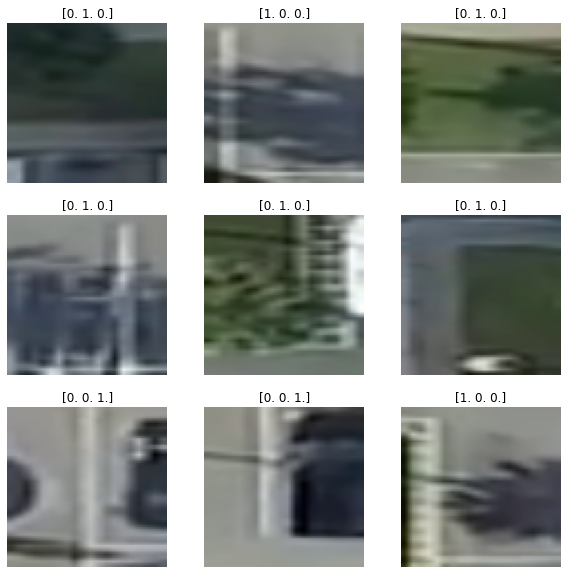

In [247]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for image, label, ax in zip(X_train, y_train, axes.flatten()):
    ax.imshow(image)
    ax.set_title(label)
    ax.set_axis_off()

# Augment the training data

Not used here because we are relying on pre-trained network to extract features for us.

In [248]:
# # Augment the images by applying random horizontal flip and rotation.
# # This is a sequence of layers that can be applied to the input data.
# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.RandomFlip('horizontal'),
#         layers.experimental.preprocessing.RandomRotation(0.1),  # 0-10% clockwise or counter-clockwise rotation
#         layers.experimental.preprocessing.Rescaling(1.0 / 255),
#     ]
# )

# # Demo the effect of augmentation
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# for i, ax in enumerate(axes.flatten()):
#     augmented = np.array(data_augmentation(X_train))
#     ax.imshow(augmented[0])
#     ax.set_title(y_train[0])
#     ax.set_axis_off()

In [249]:
def load_pretrained_models(input_shape):
    all_models = {
        'xception': {
            'model': keras.applications.Xception(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.xception.preprocess_input,
        },
        'vgg16': {
            'model': keras.applications.VGG16(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.vgg16.preprocess_input,
        },
        'resnet50': {
            'model': keras.applications.ResNet50(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.resnet.preprocess_input,
        },
    }
    return all_models


all_models = load_pretrained_models(input_shape)

In [250]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    outputs = layers.Dense(3, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

In [251]:
def fit_model(all_models, model_name, X_train, y_train, X_val, y_val, batch_size=32):
    premodel = all_models[model_name]['model']
    preprocess = all_models[model_name]['preprocess']
    model = make_model(premodel.output.shape[1:])
    # Create new training data
    X_train_pretrained = premodel.predict(preprocess(X_train))
    train_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_train_pretrained, y_train),
    ).batch(batch_size)
    # Create new validation data
    X_val_pretrained = premodel.predict(preprocess(X_val))
    val_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_val_pretrained, y_val),
    ).batch(batch_size)
    # fit model
    epochs = 50
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_ds_pretrained,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10, verbose=1, mode='auto')
        ],
        validation_data=val_ds_pretrained,
    )
    return model, history




In [252]:
model_xception, history_xception = fit_model(all_models, 'xception', X_train, y_train, X_val, y_val)

Epoch 1/50
21/21 [==============================] - 1s 14ms/step - loss: 1.0520 - accuracy: 0.6562 - val_loss: 0.7251 - val_accuracy: 0.8466
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 0.3257 - accuracy: 0.9050 - val_loss: 0.7463 - val_accuracy: 0.8466
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.1719 - accuracy: 0.9373 - val_loss: 0.7664 - val_accuracy: 0.8405
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.1098 - accuracy: 0.9538 - val_loss: 0.9439 - val_accuracy: 0.8344
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1071 - accuracy: 0.9525 - val_loss: 0.9367 - val_accuracy: 0.8466
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1762 - accuracy: 0.9346 - val_loss: 0.7139 - val_accuracy: 0.8834
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1574 - accuracy: 0.9428 - val_loss: 0.7786 - val_accuracy: 0.8834
Epoch 8/50
21/21 [=

In [253]:
model_vgg16, history_vgg16 = fit_model(all_models, 'vgg16', X_train, y_train, X_val, y_val)

Epoch 1/50
21/21 [==============================] - 1s 14ms/step - loss: 2.9732 - accuracy: 0.5570 - val_loss: 1.0655 - val_accuracy: 0.8589
Epoch 2/50
21/21 [==============================] - 0s 5ms/step - loss: 0.5308 - accuracy: 0.8795 - val_loss: 0.7042 - val_accuracy: 0.8834
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 0.2642 - accuracy: 0.9312 - val_loss: 0.6017 - val_accuracy: 0.8834
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0748 - accuracy: 0.9742 - val_loss: 0.5836 - val_accuracy: 0.9018
Epoch 5/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0503 - accuracy: 0.9807 - val_loss: 0.6246 - val_accuracy: 0.8957
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0382 - accuracy: 0.9868 - val_loss: 0.5652 - val_accuracy: 0.9202
Epoch 7/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.5562 - val_accuracy: 0.9202
Epoch 8/50
21/21 [=

In [254]:
model_resnet50, history_resnet50 = fit_model(all_models, 'resnet50', X_train, y_train, X_val, y_val)

Epoch 1/50
21/21 [==============================] - 1s 14ms/step - loss: 0.8036 - accuracy: 0.7393 - val_loss: 0.5127 - val_accuracy: 0.8834
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 0.1049 - accuracy: 0.9740 - val_loss: 0.5270 - val_accuracy: 0.9080
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.5837 - val_accuracy: 0.9018
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.9954 - val_loss: 0.6625 - val_accuracy: 0.9202
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.5992 - val_accuracy: 0.9202
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 3.1587e-04 - accuracy: 1.0000 - val_loss: 0.5849 - val_accuracy: 0.9264
Epoch 7/50
21/21 [==============================] - 0s 7ms/step - loss: 2.0664e-04 - accuracy: 1.0000 - val_loss: 0.5854 - val_accuracy: 0.9264
Epoch 8/50


# Save the model pre-trained by ResNet50

In [255]:
model_resnet50.save('spot_parked_detection_model')

INFO:tensorflow:Assets written to: spot_parked_detection_model/assets
